# Torch bridges examples

In [1]:
import copy

import numpy as np
from datasets import load_dataset
from plaid.bridges.huggingface_bridge import (
    huggingface_dataset_to_plaid,
    huggingface_description_to_problem_definition,
)
from plaid_ops.mesh.feature_engineering import update_dataset_with_sdf
from plaid_ops.mesh.transformations import (
    compute_bounding_box,
    project_on_regular_grid,
)
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as PyGDataLoader

from plaid_bridges.torch import GridFieldsAndScalarsBridge, PyGBridge
from plaid_bridges.torch.pyg import plot_sample_field, plot_sample_mesh

/home/fabien/miniconda3/envs/plaid-bridged/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Kokkos::OpenMP::initialize WARNING: OMP_PROC_BIND environment variable not set
  In general, for best performance with OpenMP 4.0 or better set OMP_PROC_BIND=spread and OMP_PLACES=threads
  For best performance with OpenMP 3.1 set OMP_PROC_BIND=true
  For unit testing set OMP_PROC_BIND=false



## Projection on constant rectilinear grid, with scalars as constant fields

In [2]:
hf_dataset = load_dataset(
    "PLAID-datasets/2D_Multiscale_Hyperelasticity", split="all_samples"
)
pb_def = huggingface_description_to_problem_definition(hf_dataset.info.description)
ids_train = pb_def.get_split("DOE_train")[:10]

dataset_train, _ = huggingface_dataset_to_plaid(
    hf_dataset, ids=ids_train, processes_number=5, verbose=False
)
n_train = len(dataset_train)
print(dataset_train)

Dataset(10 samples, 4 scalars, 0 time_series, 7 fields)


In [3]:
dims = (101, 101)
dataset_train = update_dataset_with_sdf(dataset_train, verbose=False)

bbox = compute_bounding_box(dataset_train)
projected_dataset_train = project_on_regular_grid(
    dataset_train, dimensions=dims, bbox=bbox, verbose=False
)

all_feat_ids = dataset_train[ids_train[0]].get_all_features_identifiers()
scalar_features = [f for f in all_feat_ids if "scalar" in f.values()]
field_features = [f for f in all_feat_ids if "field" in f.values()]

in_features_identifiers = [field_features[0], scalar_features[0]]
out_features_identifiers = [scalar_features[1], field_features[1]]

In [4]:
bridge = GridFieldsAndScalarsBridge(dimensions=dims)
torch_dataset = bridge.convert(
    projected_dataset_train, in_features_identifiers, out_features_identifiers
)

loader = DataLoader(
    torch_dataset,
    batch_size=2,
    shuffle=False,
)

out_feat_id = scalar_features[0]

before = copy.deepcopy(
    projected_dataset_train[ids_train[1]].get_feature_from_identifier(out_feat_id)
)

predictions = []
for batch_x, batch_y in loader:
    for torch_sample in batch_y:
        predictions.append(torch_sample.detach().cpu())

pred_projected_dataset_train = bridge.restore(
    projected_dataset_train, predictions, out_features_identifiers
)

after = copy.deepcopy(
    pred_projected_dataset_train[ids_train[1]].get_feature_from_identifier(out_feat_id)
)

print("Error after transform then inverse transform (2nd sample):")
print(np.linalg.norm(after - before) / np.linalg.norm(before))

Error after transform then inverse transform (2nd sample):
0.0


## Pytorch geometric

### Heterogenous example: 2D_Multiscale_Hyperelasticity

In [5]:
bridge = PyGBridge()

pyg_dataset = bridge.convert(dataset_train, in_features_identifiers)

print(in_features_identifiers)

[{'type': 'field', 'name': 'P22', 'base_name': 'Base_2_2', 'zone_name': 'Zone', 'location': 'Vertex', 'time': 0.0}, {'type': 'scalar', 'name': 'C11'}]


In [ ]:
loader = PyGDataLoader(
    pyg_dataset,
    batch_size=2,
    shuffle=False,
)

before = copy.deepcopy(
    dataset_train[ids_train[1]].get_feature_from_identifier(in_features_identifiers[0])
)

predictions = []
for batch in loader:
    print("batch.x.shape =", batch.x.shape)
    for pyg_samples in batch.to_data_list():
        predictions.append(
            [pyg_samples.x.detach().cpu()[:, 0], pyg_samples.scalars.detach().cpu()[0]]
        )

pred_dataset_train = bridge.restore(dataset_train, predictions, in_features_identifiers)

after = copy.deepcopy(
    pred_dataset_train[ids_train[1]].get_feature_from_identifier(
        in_features_identifiers[0]
    )
)

print("Error after transform then inverse transform (2nd sample):")
print(np.linalg.norm(after - before) / np.linalg.norm(before))

batch.x.shape = torch.Size([8811, 1])
batch.x.shape = torch.Size([11516, 1])
batch.x.shape = torch.Size([10587, 1])
batch.x.shape = torch.Size([10933, 1])
batch.x.shape = torch.Size([10121, 1])
field [2466510.44586788 2909146.94522713 2641528.01402955 ... 2561084.45448282
 2639125.54181808 2837122.93841663]
scalar 0.9122504564171015
field [2635990.95124421 2836699.53543553 2545375.510471   ... 2522925.22122997
 2809962.24004047 2351624.88318251]
scalar 1.192816728934659
field [ 978945.08244349  914004.92457582 1032058.91591856 ... 2181205.26780053
 2115255.42296398 2272828.68539392]
scalar 1.1160799683615175
field [2007014.65050153 2011032.12259225 2216942.10436705 ... 1283913.39809626
 1157354.16731249 1216767.83501231]
scalar 1.017538805728111
field [1490365.42907306 1620352.19493923 1563021.04811681 ... 1397953.50230381
 1392187.84300114 1405478.64773852]
scalar 0.908120916600461
field [2149272.47901395 2031773.77011635 2071611.74227248 ... 2019310.36297522
 1761512.20449954 1871258

TypeError: len() of unsized object

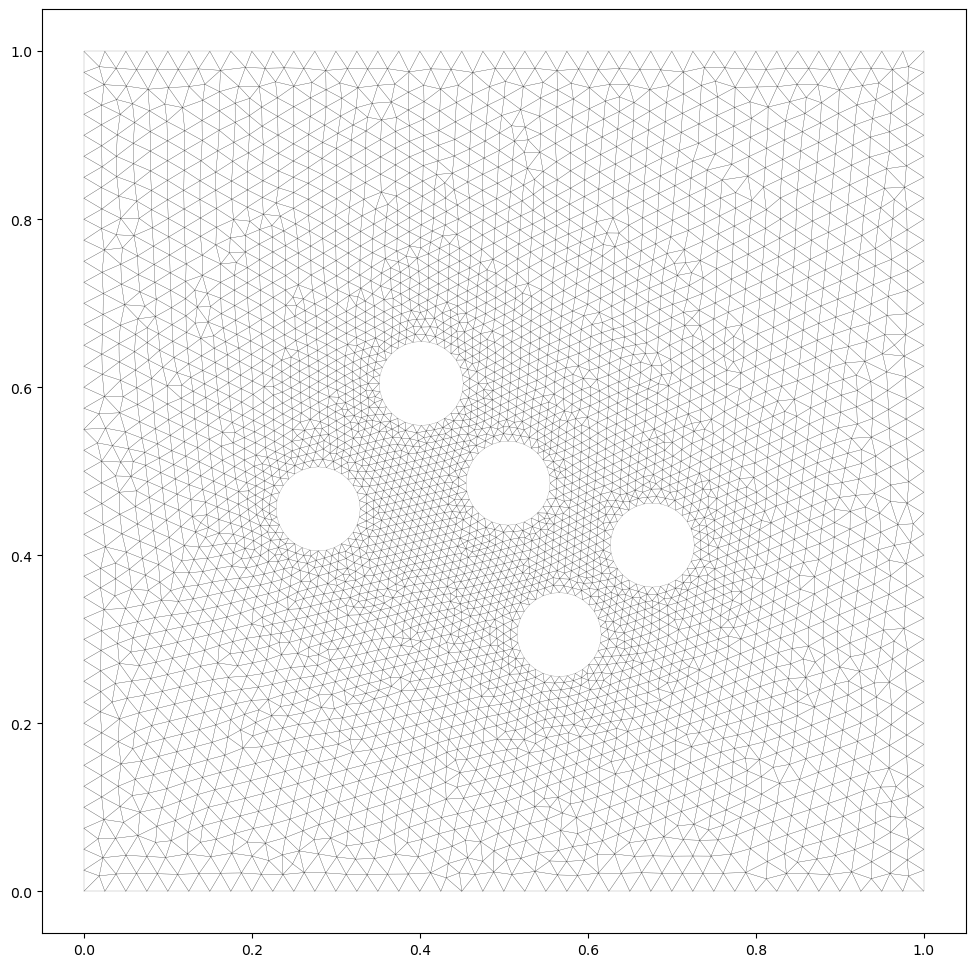

In [ ]:
plot_sample_mesh(pyg_dataset[0])

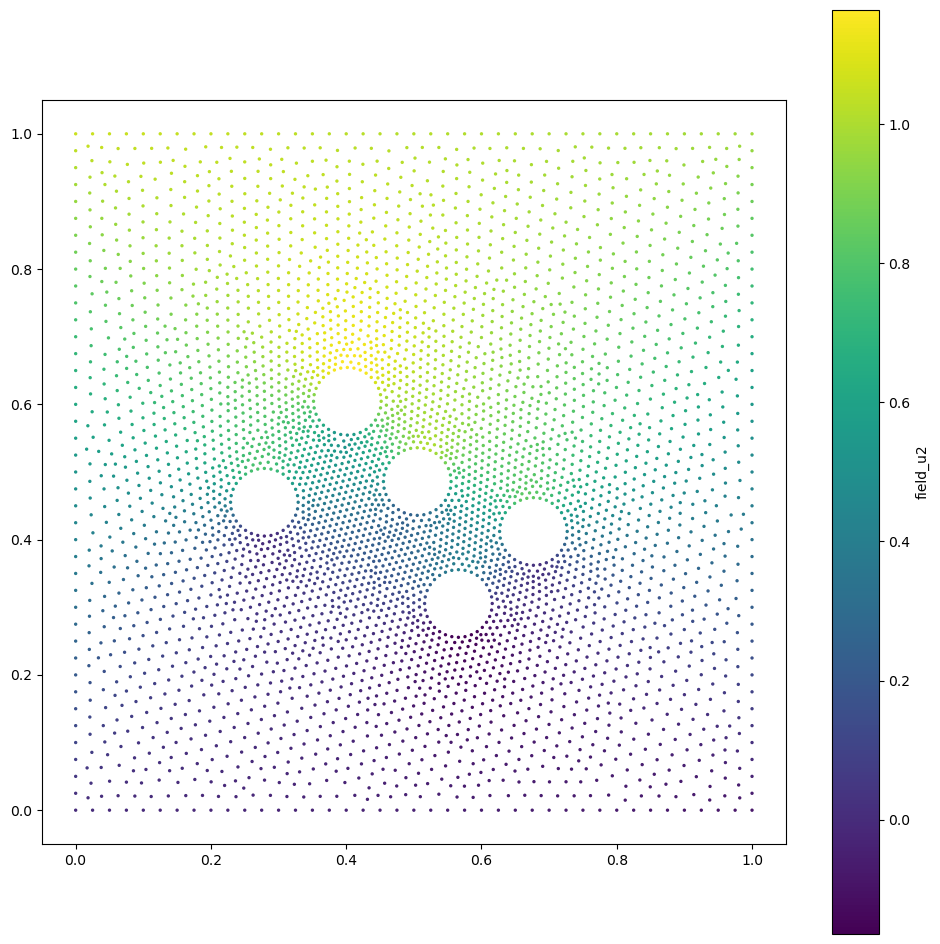

In [ ]:
plot_sample_field(pyg_dataset[0], pyg_dataset[0].field_names[0])

### Multi-base example: VKI-LS59

In [ ]:
hf_dataset = load_dataset("PLAID-datasets/VKI-LS59", split="all_samples")
pb_def = huggingface_description_to_problem_definition(hf_dataset.info.description)
ids_train = pb_def.get_split("train")[:10]

dataset_train, _ = huggingface_dataset_to_plaid(
    hf_dataset, ids=ids_train, processes_number=5, verbose=False
)
n_train = len(dataset_train)
print(dataset_train)

Dataset(10 samples, 8 scalars, 0 time_series, 8 fields)


In [ ]:
all_feat_ids = dataset_train[ids_train[0]].get_all_features_identifiers()
scalar_features = [f for f in all_feat_ids if "scalar" in f.values()]

#### Base "Base_1_2"

In [ ]:
field_features = [
    f for f in all_feat_ids if "field" in f.values() if f["base_name"] == "Base_1_2"
]
features_identifiers = scalar_features + field_features

bridge = PyGBridge(base_name="Base_1_2")

pyg_dataset = bridge.convert(dataset_train, features_identifiers)

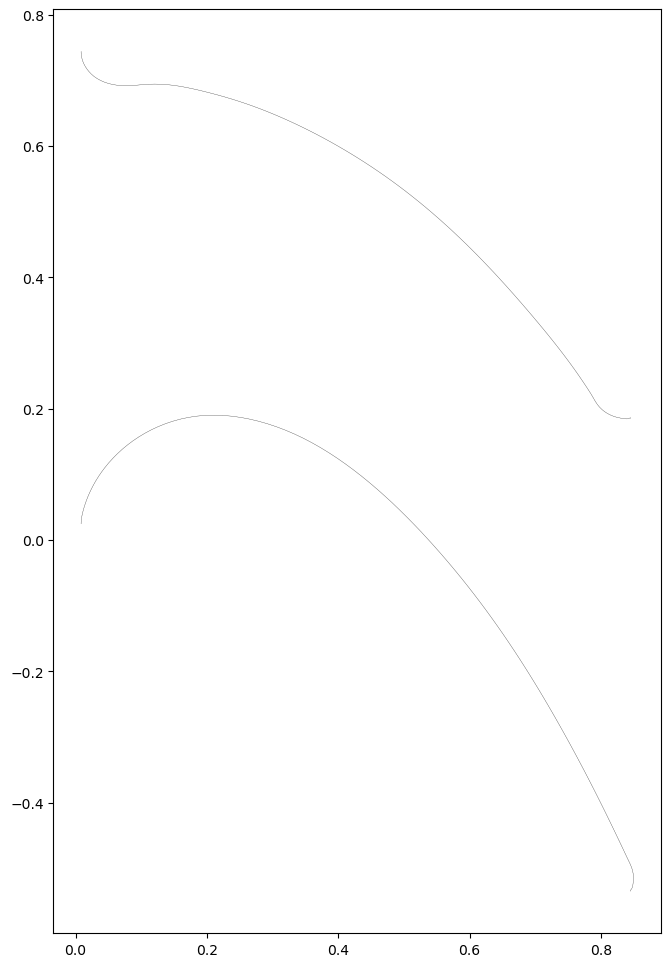

In [ ]:
plot_sample_mesh(pyg_dataset[0])

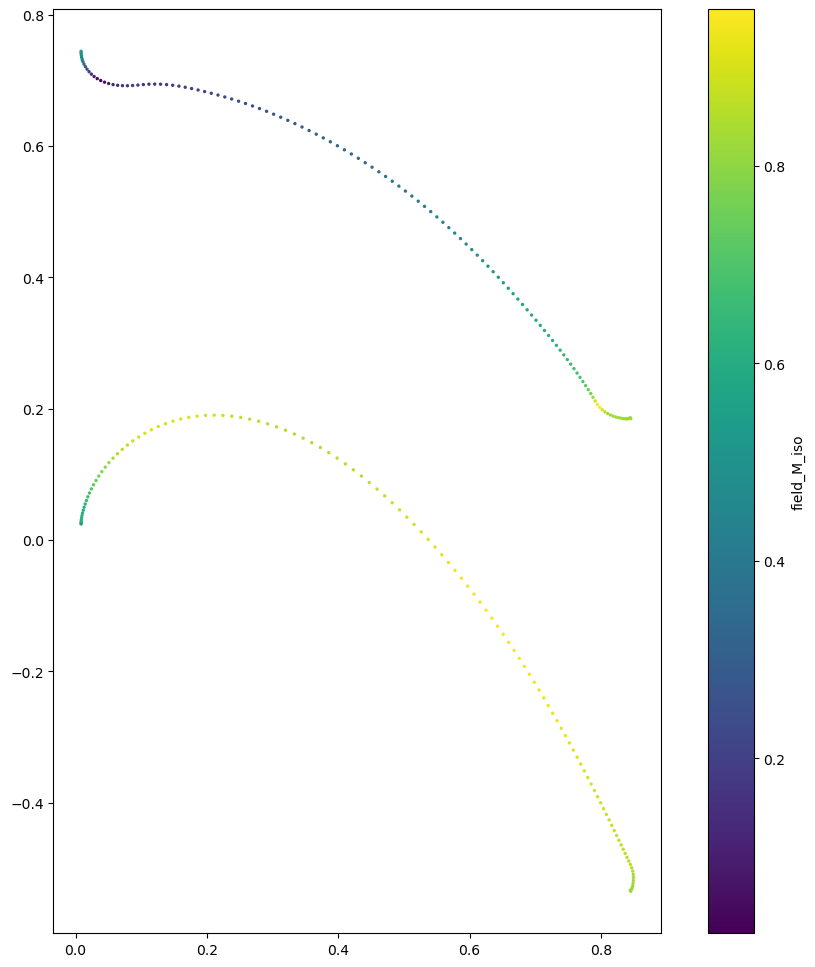

In [ ]:
plot_sample_field(pyg_dataset[0], "M_iso")

In [ ]:
print("field_names =", pyg_dataset[0].field_names)
print("scalar_names =", pyg_dataset[0].scalar_names)
print("scalars =", pyg_dataset[0].scalars)

field_names = ['M_iso']
scalar_names = ['Pr', 'Q', 'Tr', 'angle_in', 'angle_out', 'eth_is', 'mach_out', 'power']
scalars = tensor([9.7290e-01, 2.6711e-01, 9.9834e-01, 4.5507e+01, 6.1895e+01, 2.1238e-01,
        8.1003e-01, 1.9118e-03], dtype=torch.float64)


#### Base "Base_2_2"

In [ ]:
field_features = [
    f for f in all_feat_ids if "field" in f.values() if f["base_name"] == "Base_2_2"
]
features_identifiers = scalar_features + field_features

bridge = PyGBridge(base_name="Base_2_2")

pyg_dataset = bridge.convert(dataset_train, features_identifiers)

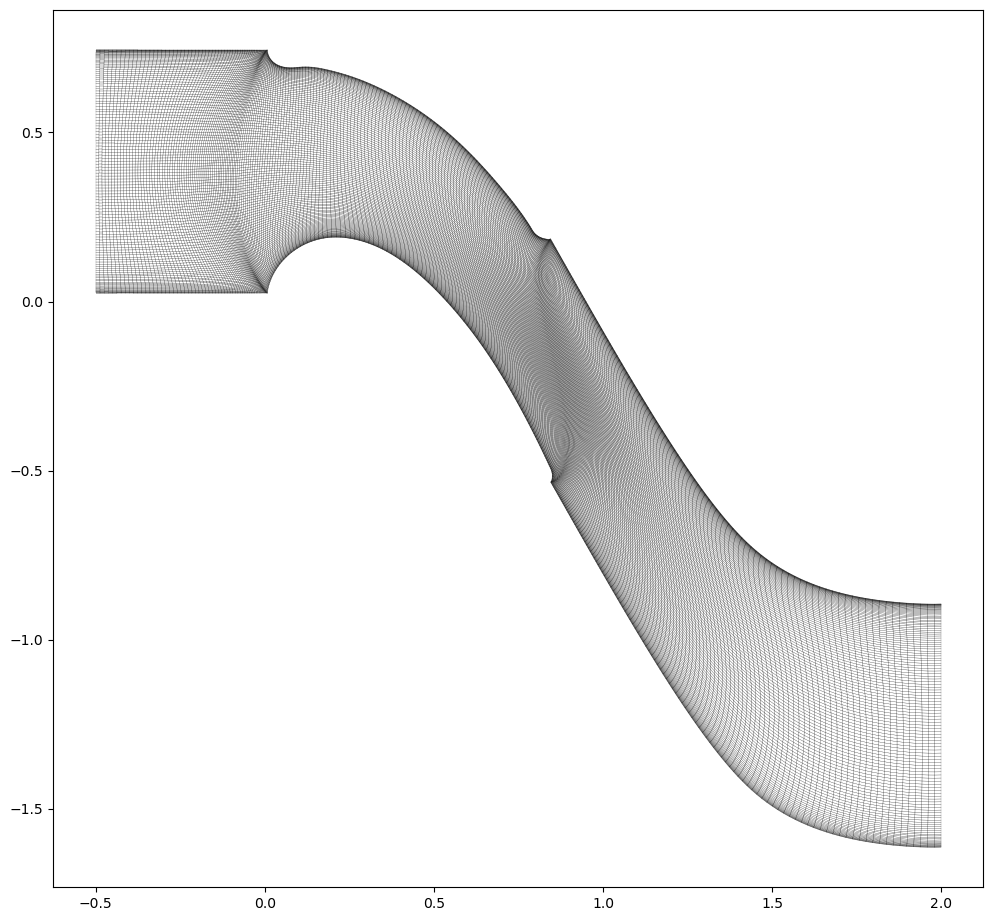

In [ ]:
plot_sample_mesh(pyg_dataset[0])

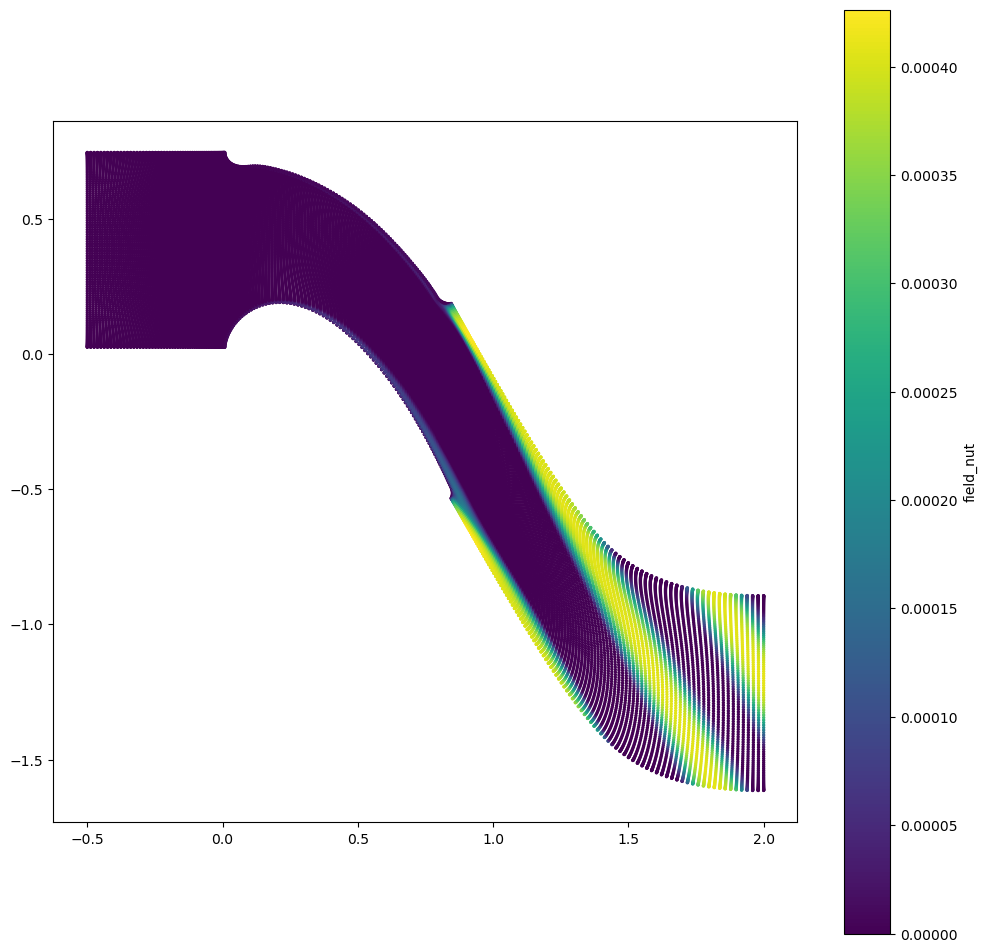

In [ ]:
plot_sample_field(pyg_dataset[0], "nut")